# Chapter 9: Apply Deep Learning to Any Game

Games in the OpenAI Gym environment are designed for reinforcement learning, how to win a game with a deep learning game strategy sometimes proves challenging. 

The CartPole game is such a case. Winning is defined as making the Cart Pole stand upright for at least 195 consecutive steps. If we randomly choose actions, we'll end up with all losing games. Then the simulated data have no use for training purpose. 

In such cases, we need to be creative and redefine what's considered "winning." Specifically, in this chapter, you'll use random actions to simulate 10,000 games. The last ten steps of the game are considered "losing" while all steps before that are considered "winning." You can think of winning as the ability to stay upright for at least another ten steps. You can use other cutoff values such as 15 or 20 instead of 10 steps, and the strategy works just the same. 

After that, you'll feed the data into a deep neural network. Once the model is trained, the agent will ask the model this question: for the given situation, what's the probability of winning if I were to take move left hypothetically; also for the given situation, what's the probability of winning if I were to move right hypothetically?. The agent will pick the action with the higher probability of winning. Such a strategy will help the agent win the game 100% of the time. That is, the agent can stay upright for at least 195 steps in every game.

At the end of this chapter, you'll create an animation to show how the game is played with and without deep learning strategy. Readers can see the two scenarios side by side. 
The animation looks as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/compare_cartpole.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 9}}$<br>
***
We'll put all files in Chapter 9 in a subfolder /files/ch09. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch09", exist_ok=True)

## 1. Play the Cart Pole Game in OpenAI Gym
As we discussed in Chapter 8, you need to install the ***gym*** library first. Further, we'll use version 0.15.7 of the library because newer versions are not compatible with the ***Baselines*** library, which we need to play the Atari games.

Before you get started, install the OpenAI Gym library as follows:

`pip install gym==0.15.7`


### 1.1. Features of the Cart Pole Game 

If you go to the official Cartpole game website https://gym.openai.com/envs/CartPole-v0/. 

The problem is considered solved as getting an average reward of 195 or above in 100 consecutive trials. 

The code in the cell below will get you started:

In [1]:
import gym 
 
env = gym.make("CartPole-v0")
env.reset()                    
env.render()

C:\Users\mark\.conda\envs\animatedML\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


True


We can also print out all possible actions and states of the game as follows:

In [3]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space in the Cart Pole game is {actions}")

# Print out all possible states in this game
states = env.observation_space
print(f"The state space in the Cart Pole game is {states}")

env.close()

The action space in the Cart Pole game is Discrete(2)
The state space in the Cart Pole game is Box(4,)


The action space in the Cart Pole game has two values: 0 and 1, with the following meanings:
* 0: moving left
* 1: moving right

The state in the Cart Pole game is a collection of four values, with the following meanings:

* The position of the cart, with values between -4.8 and 4.8; 
* The velociyt of the cart, with values between -4 and 4; 
* The angle of the pole, with values between -0.42 and 0.42;
* The angular velocity of the pole, with values between -4 and 4; 


The agent earns a reward of 1 for every time that the pole stays upright. If the pole is more than 15 degrees from 
 vertical or the cart moves more than 2.4 units from the center, the agent loses the game.

### 1.2. Play A Full Game
You can play a complete game as follows by using random actions.

In [4]:
import gym

env = gym.make('CartPole-v0')
env.reset()   

while True:
    action = actions.sample()
    print(action)
    new_state, reward, done, info = env.step(action)
    env.render()
    print(new_state, reward, done, info)    
    if done == True:
        break

env.close()        

0
[-0.00077322 -0.1786936   0.00362296  0.28238639] 1.0 False {}
0
[-0.00434709 -0.37386704  0.00927069  0.57620978] 1.0 False {}
1
[-0.01182443 -0.17887626  0.02079488  0.28646172] 1.0 False {}
1
[-0.01540195  0.01594305  0.02652412  0.00040919] 1.0 False {}
0
[-0.01508309 -0.17954906  0.0265323   0.30134138] 1.0 False {}
0
[-0.01867407 -0.37503893  0.03255913  0.60227256] 1.0 False {}
1
[-0.02617485 -0.18038716  0.04460458  0.32002035] 1.0 False {}
0
[-0.0297826  -0.37611503  0.05100499  0.62642954] 1.0 False {}
1
[-0.0373049  -0.18174075  0.06353358  0.35023625] 1.0 False {}
1
[-0.04093971  0.01242282  0.0705383   0.07824482] 1.0 False {}
0
[-0.04069126 -0.18363572  0.0721032   0.39232236] 1.0 False {}
0
[-0.04436397 -0.37970288  0.07994965  0.70683892] 1.0 False {}
1
[-0.05195803 -0.18577423  0.09408642  0.44035529] 1.0 False {}
0
[-0.05567351 -0.38209301  0.10289353  0.76115164] 1.0 False {}
0
[-0.06331537 -0.57847056  0.11811656  1.0843574 ] 1.0 False {}
0
[-0.07488478 -0.7749359

The above cell used several methods in the game environment:
* The sample() method randomly selects an action from the action space. That is, it will return one of the values among {0, 1}. 
* The step() method is where the agent is interacting with the environment, and it takes the agent’s action as input. The output are four values: the new state, the reward, a variable *done* indicating whether the game has ended. The *info* variable provides some information about the game. 
* The render() method shows a diagram of the resulting state. 

The game loop is an infinite *while* loop. If the *done* variable returns a value *True*, the game ends, and we stop the infinite while loop.

Note that since the actions are chosen randomly, when you run the script, you’ll most likely get different results.

## 2. Deep Learning Game Strategies: Generating Data

In the next few sections, you’ll learn how to use deep neural networks to train intelligent game strategies.

First, you’ll learn how to generate simulated game data for training purpose. However, you'll see that all the rewards are 1. As soon as the game ends, another episode of game starts again. Therefore, we need to creatively define what's considered winning. 

Once you have a trained model, you’ll learn how to use the model to design a best-move game strategy and play against the computer. Finally, you’ll test the effectiveness of the game.

### 2.1. How to Define Winning and Losing?
In the Frozen Lake game in Chapter 8, winning and losing is easy to define: if the agent reaches the goal, it's a win. On the other hand, if the agent falls into one of the hole, it's a loss. 

There could be other ways of defining winning and losing, but we'll define a step as a win if it survives at least another ten steps. Otherwise, it's a losing strategy. 


### 2.2. Prepare Data for the Neural Network
How to use neural network to train a game strategy in this case? Here is a summary of what we’ll do to train the game strategy:
1. We’ll let the player randomly choose actions and complete a game and record the whole game history. The game history will contain all the intermediate states and actions from the very first move to the very last move.
2. We then associate each state-action pair with a game outcome (win or lose). The state-action pair is similar to X (i.e., image pixels) in our image classification problem, and the outcome is similar to y (i.e., image labels such as horse, deer, airplane and so on) in the image classification problem.
3. We’ll simulate a large number of games, say, 10000 of them. Use the histories of the games and the corresponding outcome as X and y pairs to feed into a Deep Neural Networks model. After training is done, we have a trained model.
4. At each move of the game, we look at all possible next moves, and feed the hypothetical state-action pair into the pretained model. The model will tell you the probability of winning the game if that state-action pair were chosen.
5. You select the move with the highest chance of winning based on the model's predictions.

#### Simulate One Game

First we’ll simulate one game and record the whole game history and the game outcome. The script below accomplishes that:

In [3]:
import gym
import numpy as np

env = gym.make('CartPole-v0')
# create lists to record all game histories and outcomes 
history = []
winlose = []
state = env.reset()
while True:
    # randomly choose an action  
    action = env.action_space.sample()
    # make a move
    new_state, reward, done, _ = env.step(action)
    # recording game hisotry
    history.append([state, action, new_state, reward, done])
    # temporarily record the step as winning
    winlose.append(1)
    # prepare for the next round
    state = new_state
    # stop if the game is over
    if done==True:
        break  

# The last ten steps of the game is considered not winning
for i in range(len(history)):
    if len(history)-i<=10 and len(history)<195:
        winlose[i] = 0
        
print("the game history is", history)     
print("the win/loss history is", winlose) 
print(f"the game has lasted {len(history)} steps") 
env.close()

the game history is [[array([-0.00482245, -0.03372653,  0.01694466,  0.01906569]), 0, array([-0.00549698, -0.22908734,  0.01732597,  0.31704633]), 1.0, False], [array([-0.00549698, -0.22908734,  0.01732597,  0.31704633]), 1, array([-0.01007873, -0.0342164 ,  0.0236669 ,  0.02987737]), 1.0, False], [array([-0.01007873, -0.0342164 ,  0.0236669 ,  0.02987737]), 1, array([-0.01076306,  0.1605583 ,  0.02426445, -0.25524544]), 1.0, False], [array([-0.01076306,  0.1605583 ,  0.02426445, -0.25524544]), 0, array([-0.00755189, -0.03490154,  0.01915954,  0.04499106]), 1.0, False], [array([-0.00755189, -0.03490154,  0.01915954,  0.04499106]), 0, array([-0.00824992, -0.23029292,  0.02005936,  0.34365689]), 1.0, False], [array([-0.00824992, -0.23029292,  0.02005936,  0.34365689]), 0, array([-0.01285578, -0.42569441,  0.0269325 ,  0.64259722]), 1.0, False], [array([-0.01285578, -0.42569441,  0.0269325 ,  0.64259722]), 1, array([-0.02136967, -0.23095801,  0.03978444,  0.35851575]), 1.0, False], [array

The game has lasted 23 steps. So the first 13 steps are classifed as winning steps, while the last ten are losing steps. 

#### Simulate Many Games
Next, we'll simulate 10,000 games and record all the intermediate steps and outcomes. 

In [4]:
import gym
import numpy as np

env = gym.make('CartPole-v0')
# create lists to record all game histories and outcomes 
histories = []
winloses = []
# Define one_game() function
def one_game():
    history = []
    winlose = []
    state = env.reset()
    while True:
        # randomly choose an action  
        action = env.action_space.sample()
        # make a move
        new_state, reward, done, _ = env.step(action)
        # recording game hisotry
        history.append([state, action, new_state, reward, done])
        # temporarily record the step as winning
        winlose.append(1)
        # prepare for the next round
        state = new_state
        # stop if the game is over
        if done==True:
            break  
    return history, winlose

# Play 10,000 games
for j in range(10000):
    # play a game
    history, winlose = one_game()
    # The last ten steps of the game is considered not winning
    for i in range(len(history)):
        if len(history)-i<=10 and len(history)<195:
            winlose[i] = 0
    # record history and outcome
    histories.append(history)
    winloses.append(winlose)

Next, we'll save the simulated data on the computer for later use. 

In [5]:
import pickle
# save the simulation data on your computer
with open('files/ch09/CartPole_games.pickle', 'wb') as fp:
    pickle.dump((histories,winloses), fp)

You can load up the saved simulation data from your computer, and print out the first game.

In [7]:
# read the data and print out the first 10 games
with open('files/ch09/CartPole_games.pickle', 'rb') as fp:
    histories, outcomes=pickle.load(fp)
    
from pprint import pprint
pprint(histories[:1])    
pprint(outcomes[:1])  

[[[array([-0.0299482 ,  0.01083027, -0.0244265 ,  0.0119515 ]),
   0,
   array([-0.0297316 , -0.18393301, -0.02418747,  0.29682859]),
   1.0,
   False],
  [array([-0.0297316 , -0.18393301, -0.02418747,  0.29682859]),
   1,
   array([-0.03341026,  0.01152524, -0.0182509 , -0.00338346]),
   1.0,
   False],
  [array([-0.03341026,  0.01152524, -0.0182509 , -0.00338346]),
   1,
   array([-0.03317975,  0.20690412, -0.01831857, -0.30176843]),
   1.0,
   False],
  [array([-0.03317975,  0.20690412, -0.01831857, -0.30176843]),
   0,
   array([-0.02904167,  0.01204798, -0.02435394, -0.01491862]),
   1.0,
   False],
  [array([-0.02904167,  0.01204798, -0.02435394, -0.01491862]),
   0,
   array([-0.02880071, -0.18271639, -0.02465231,  0.26998195]),
   1.0,
   False],
  [array([-0.02880071, -0.18271639, -0.02465231,  0.26998195]),
   0,
   array([-0.03245504, -0.37747803, -0.01925267,  0.5547886 ]),
   1.0,
   False],
  [array([-0.03245504, -0.37747803, -0.01925267,  0.5547886 ]),
   1,
   array([-0

Next we'll train the deep neural network using the simulated data.

## 3. Deep Learning Game Strategies: Train the Deep Neural Network

We'll train the deep neural network so that it can learn from the simulated data. To do that, we'll first prepare the data so that we can feed them into the neural network.

### 3.1. Preparing the Data

We'll create X and y for each game step and put them together for training. 

Since the outcome variable is either 1 or 0, this is similar to a binary classification problem. 

What we are doing here is to associate each state and action combination (s,a) with the outcome 1 or 0.

In [8]:
# Create empty X and y lists
X, y = [], []    
# Create X and y for each game step
for history, winlose in zip(histories, outcomes):
    for i in range(len(history)):
        state, action, new_state, reward, done = history[i]
        s = np.array(state).reshape((4,1))
        a = np.array(action).reshape((1,1))
        sa = np.concatenate([s, a], axis = 0)
        # Each observation of X is a (state, action) combination
        X.append(sa.reshape(-1,))
        # Each y is the outcome for the state action combination
        y.append(winlose[i])
        
# Print the first five observations of X and y
from pprint import pprint
pprint(X[:5])
pprint(y[:5])
# See what's the average value of y
print(np.mean(np.array(y).reshape(-1,)))

[array([-0.0299482 ,  0.01083027, -0.0244265 ,  0.0119515 ,  0.        ]),
 array([-0.0297316 , -0.18393301, -0.02418747,  0.29682859,  1.        ]),
 array([-0.03341026,  0.01152524, -0.0182509 , -0.00338346,  1.        ]),
 array([-0.03317975,  0.20690412, -0.01831857, -0.30176843,  0.        ]),
 array([-0.02904167,  0.01204798, -0.02435394, -0.01491862,  0.        ])]
[1, 1, 1, 1, 1]
0.5520433080762739


The output above shows that the averge value of y is about 0.552. This means 55.2% of steps are wins and the rest 44.85 are losses. 

Finally we save the processed data for later use:

In [9]:
# save the processed data on your computer
with open('files/ch09/CartPoleXy.pickle', 'wb') as fp:
    pickle.dump((X,y),fp)

### 3.2. Train the Deep Neural Network
Now that the dataset is ready, we are ready to train our deep neural network. 

Here we are essentially performing a binary classification. We classify each state-action pair into win or lose. The output layer has one neuron with sigmoid activation. So we can think of the output as the probability of winning the game. 

There are two hidden layers in the model, with 64 and 16 neurons, respectively. But we do have a lot of freedom here. More layers with various numbers of neurons will generate similar results. 

Later, we'll use the trained model to play the Cart Pole game. When playing, at each state, we'll ask the following question:
1. If I choose action 0 (i.e., move left), what's the probability of winning the game? We'll combine the current state and action 0 and feed this state-action pair to the trained deep neural network and get a probability; let's call it p(win|s,a0).
2. If I choose action 1 (i.e., move right), what's the probability of winning the game? We'll use the trained neural network and get p(win|s,a1).
We then compare p(win|s,a0) with p(win|s,a1) and pick the action that leads to the higher p(win|s,a). 

In [ ]:
# import needed modules
from tensorflow.keras.models import Sequential
from random import choice
import pickle
from tensorflow.keras.layers import Dense
import numpy as np
from pprint import pprint

# load the data       
with open('files/ch09/CartPoleXy.pickle', 'rb') as fp:
    X, y = pickle.load(fp)

X = np.array(X).reshape((-1, 5))
y = np.array(y).reshape((-1, 1))

# Create a model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(5,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy'])

model.fit(X,y, epochs=50)

model.save('files/ch09/trained_cartpole.h5')

Now that the model is trained, we can use it to play the game.

## 4. Play the Game with the Trained Model
To play the game with the trained model, we'll look at the state at each move, and hypothetically take actions 0 and 1. Then we use the trained model to predict the probability of winning with each of the two state-action pairs. We'll pick the action that leads to the higher probability of winning. We repeat at each step until the game ends.

In [5]:
# import needed modules
from tensorflow.keras.models import Sequential
from random import choice
import pickle
from tensorflow.keras.layers import Dense
import numpy as np
from pprint import pprint
import tensorflow as tf


reload = tf.keras.models.load_model("files/ch09/trained_cartpole.h5")


import gym

env = gym.make('CartPole-v0')
state = env.reset()

frames = []

for i in range(1,201):
    # Save the screen for later use
    frames.append(env.render(mode='rgb_array'))
    # Use the trained model to predict the prob of winning 
    s = np.array(state).reshape((4,1))
    a0 = np.array([0]).reshape((1,1))
    a1 = np.array([1]).reshape((1,1))    
    sa0 = np.concatenate([s, a0], axis = 0).reshape(-1,5)
    sa1 = np.concatenate([s, a1], axis = 0).reshape(-1,5)
    sa = np.concatenate([sa0, sa1], axis=0).reshape(-1,5)
    # pick the action with higher probability of winning
    action = np.argmax(reload.predict(sa))
    new_state, reward, done, info = env.step(action)
    state = new_state
    if done == True:
        print(f"score is {i}")
        break
env.close()

1/1 [==============================] - ETA: 0s

C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step
score is 200


The cart pole stays upright for all 200 steps. So the deep learning game strategy works really well!!!

Next, we'll create an animation to compare two games: one with random moves, and the other with deep learning game strategies.

## 5. Compare Two Games
We have alredy recorded all the frames in a game with deep learning strategies. 

Next, we'll record all the grames in a game with random moves. We'll then put the frames side by side with frames from the game with deep learning strategies.

### 5.1. Record A Game with Random Moves
We will make random moves, and play the Cart Pole game for 200 steps. We then record all frames in a list called *random_frames*.

In [6]:
env = gym.make('CartPole-v0')
state = env.reset()

random_frames=[]
# Record 200 frames
for i in range(1,201):
    random_frames.append(env.render(mode='rgb_array'))
    # pick a random action 
    action = env.action_space.sample()
    # play the game
    new_state, reward, done, info = env.step(action)
    state = new_state

env.close()

C:\Users\hlliu2\Anaconda3\envs\animatedML\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


We have now recorded 200 frames in a random-move game.

### 5.2. How to Combine Frames without Saving Them
Each Cart Pole game has 200 frames. We want to combine the frames from two games in each step. If we have to save each combined frame, that would be too many pictures and take too much space on your computer. 

Instead, we'll find a way to combine two frames without saving them. 

Here is how you can do it.

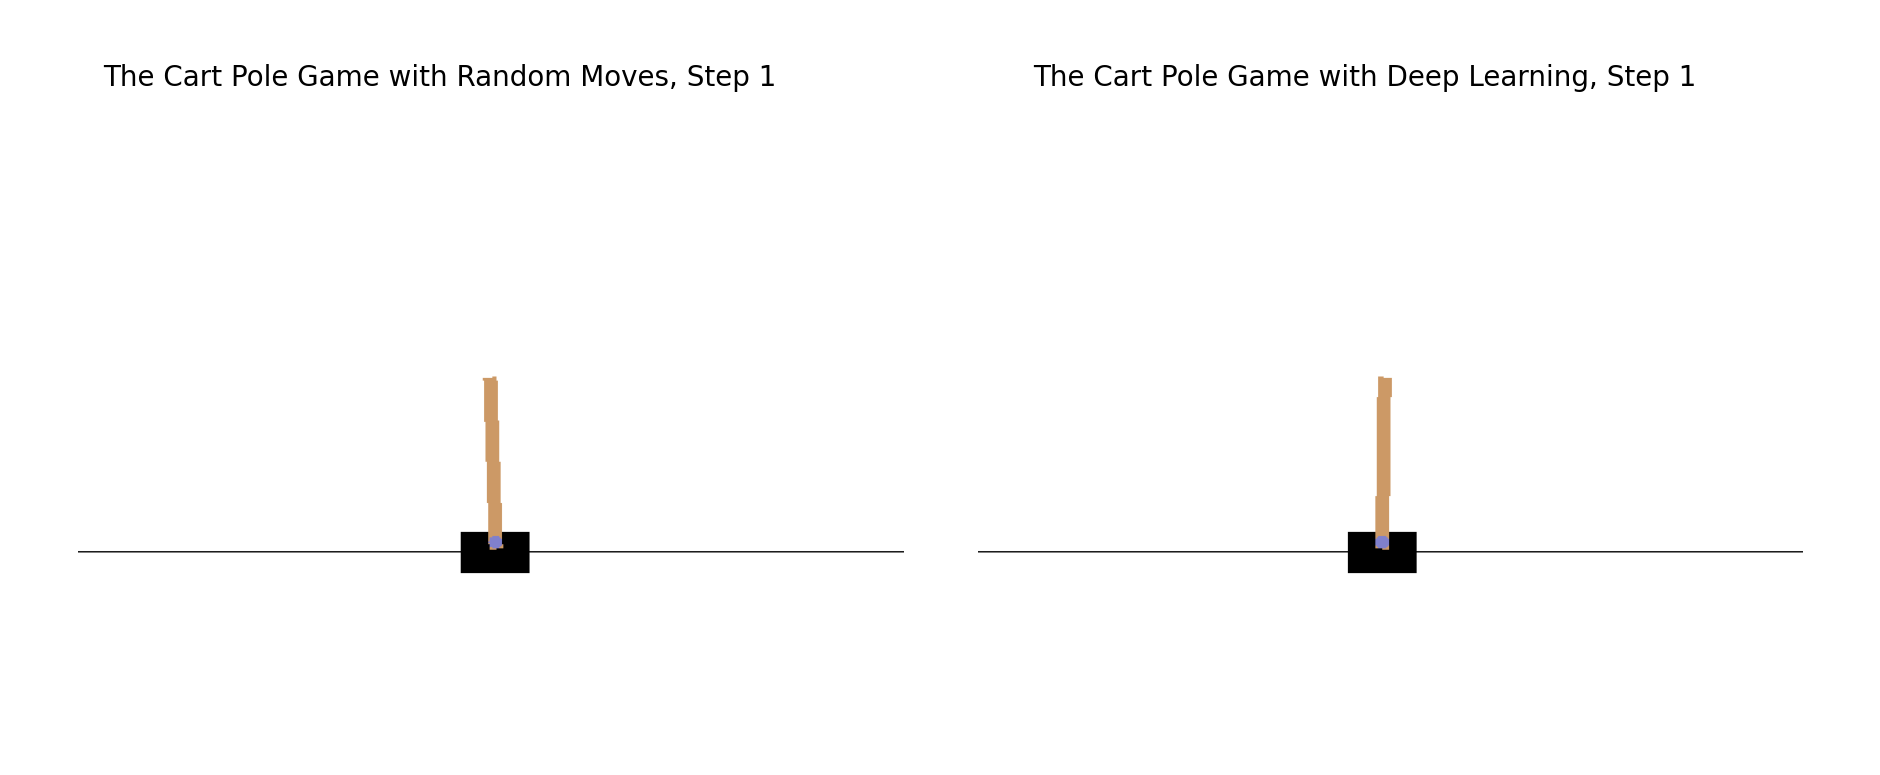

In [7]:
from matplotlib import pyplot as plt

# Create a list to store the combined frames
combined = []

fig = plt.figure(figsize=(24,10), dpi=100)
ax = fig.add_subplot(111) 
ax.set_xlim(-10, 10)
ax.set_ylim(-5,5)
plt.axis("off")
ax.text(-9,4,"The Cart Pole Game with Random Moves, Step 1",fontsize=20)
ax.text(1,4,"The Cart Pole Game with Deep Learning, Step 1",fontsize=20)
# Add the frame from the random-move game to the left
newax = fig.add_axes([0.05, 0.2, 0.55, 0.55])
newax.imshow(random_frames[0])
newax.axis('off')    

# Add the frame from the deep-learning game to the right
newax2 = fig.add_axes([0.425, 0.2, 0.55, 0.55])
newax2.imshow(frames[0])
newax2.axis('off') 
# plot the picture 
fig.canvas.draw()
# Now we can save it to a numpy array.
twoframes = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
twoframes = twoframes.reshape(fig.canvas.get_width_height()[::-1]+ (3,))
combined.append(twoframes)

The combined frame is shown above. 

More important, we can now save the combined frame as a numpy array in a list temporarily without saving on your computer. 

### 5.3. Combine Frames in Each Step
Next, we'll combine the two frames in each of the 200 steps.

In [9]:
# Create a list to store the combined frames
combined = []

for step in range(0,200):
      
    fig = plt.figure(figsize=(24,10), dpi=100)
    ax = fig.add_subplot(111) 
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5,5)
    #plt.grid()
    plt.axis("off")
    ax.text(-9,4,f"The Cart Pole Game with Random Moves, Step {step+1}",fontsize=20)
    ax.text(1,4,f"The Cart Pole Game with Deep Learning, Step {step+1}",fontsize=20)
    # Add the frame from the random-move game to the left
    newax = fig.add_axes([0.05, 0.2, 0.55, 0.55])
    newax.imshow(random_frames[step])
    newax.axis('off')    

    # Add the frame from the deep-learning game to the right   
    newax2 = fig.add_axes([0.425, 0.2, 0.55, 0.55])
    newax2.imshow(frames[step])
    newax2.axis('off')

    # plot the picture 
    fig.canvas.draw()
    # Now we can save it to a numpy array.
    twoframes = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    twoframes = twoframes.reshape(fig.canvas.get_width_height()[::-1]+ (3,))
    combined.append(twoframes)
    plt.close(fig)

We now have 200 combined frames.

### 5.4. Create An Animation of Combined Frames
We'll use the ***imageio*** library to convert the 200 combined frames into an animation.

In [11]:
import imageio
imageio.mimsave('compare_cartpole.gif', combined, fps=12) 

The animation looks as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/compare_cartpole.gif" />